In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from logreg_ccd import LogRegCCD
from synthetic_data import generate_synthetic_data

In [50]:
p = 0.5  # Class prior probability
n = 100   # Number of samples
d = 25    # Dimension
g = 0.7  # Covariance matrix multiplier

X, y = generate_synthetic_data(p, n, d, g)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [51]:
log_reg_ccd = LogRegCCD(max_iter=1000)
log_reg_ccd.fit(X_train, y_train, X_train, y_train, np.logspace(-4, 0, 100))
accuracy_log_reg_ccd = log_reg_ccd.validate(X_test, y_test, accuracy_score)
print("Accuracy of CCD Logistic Regression:", accuracy_log_reg_ccd)

Accuracy of CCD Logistic Regression: 0.6333333333333333


In [52]:
# sklearn logitsic regression with no penalty
log_reg = LogisticRegression(penalty=None)
log_reg.fit(X_train, y_train)
accuracy_log_reg = accuracy_score(y_test, log_reg.predict(X_test))
print("Accuracy of sklearn Logistic Regression with no penalty:", accuracy_log_reg)

# sklearn logistic regression with L1 penalty
log_reg_l1 = LogisticRegression(penalty='l1', solver='liblinear')
log_reg_l1.fit(X_train, y_train)
accuracy_log_reg_l1 = accuracy_score(y_test, log_reg_l1.predict(X_test))
print("Accuracy of sklearn Logistic Regression with L1 penalty:", accuracy_log_reg_l1)

Accuracy of sklearn Logistic Regression with no penalty: 0.6
Accuracy of sklearn Logistic Regression with L1 penalty: 0.5666666666666667


In [53]:
log_reg_ccd.best_beta, log_reg_ccd.best_lambda

(array([ 0.45714286,  3.16374169,  0.54320252,  0.7122843 , -2.36189506,
        -0.03897773,  1.90563668, -0.89351754, -0.20721392,  0.12789438,
        -0.76598076, -0.3264608 ,  0.42680341, -1.25514921,  1.89400201,
        -0.88170027, -0.36935776, -0.59216834,  1.05992528, -1.70473075,
         0.06506511, -1.22303054,  0.68750505,  0.65604314, -0.52731061,
         1.49695148]),
 np.float64(0.0001))

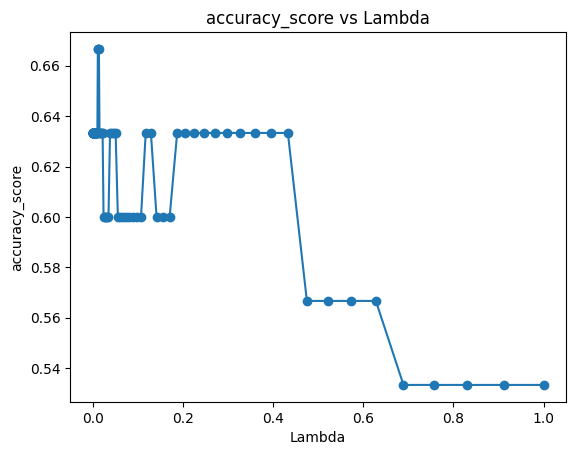

In [54]:
log_reg_ccd.plot(accuracy_score, X_train, y_train, X_test, y_test, np.logspace(-4, 0, 100))

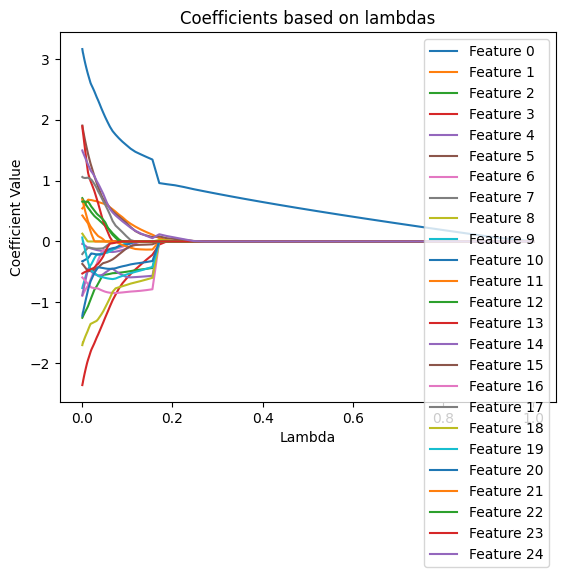

In [55]:
log_reg_ccd.plot_coefficients(np.logspace(-4, 0, 100), X_train, y_train)